# In-Depth Analysis

At this point, it's time to apply some machine learning techniques to the data and try building some predictive models. We'll start by importing the data and libraries needed to start.

In [1]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl 
import seaborn as sns
from scipy import stats


#Test-Train Split and Confusion Matrix
from sklearn.model_selection import train_test_split, StratifiedKFold 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#Logistic Regression
from sklearn.linear_model import LogisticRegression

#MultinomialNB classifier
from sklearn.naive_bayes import MultinomialNB

#KNN
from sklearn.neighbors import KNeighborsClassifier

#SVC
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import classification_report, confusion_matrix

#Random Forest
from sklearn.ensemble import RandomForestClassifier

#LightGBM
import lightgbm as lgb
import scipy as sp
from sklearn.feature_selection import SelectFromModel

import warnings
warnings.filterwarnings('ignore')


/Users/caitlinewing/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
#Import data

#File Names
adoptfile  = 'tidy_data/adoption_speed.csv'
colorfile  = 'tidy_data/color_labels.csv'
wormfile   = 'tidy_data/dewormed.csv'
breedfile  = 'tidy_data/dog_breeds.csv'
datafile   = 'tidy_data/dog_data.csv'
furfile    = 'tidy_data/fur_length.csv'
healthfile = 'tidy_data/health.csv'
sizefile   = 'tidy_data/size.csv'
statefile  = 'tidy_data/state_labels.csv'
fixedfile  = 'tidy_data/sterilized.csv'
vacfile    = 'tidy_data/vaccine.csv'

#Import Files
adptspeed  = pd.read_csv(adoptfile)
color      = pd.read_csv(colorfile)
dewormed   = pd.read_csv(wormfile)
breeds     = pd.read_csv(breedfile)
dog_data   = pd.read_csv(datafile)
fur_length = pd.read_csv(furfile)
health     = pd.read_csv(healthfile)
adult_size = pd.read_csv(sizefile)
state=pd.read_csv(statefile)
fixed = pd.read_csv(fixedfile)
vaccinated = pd.read_csv(vacfile)

In [3]:
#Separate dog_data into the original test data and training data files to work with
dogs_orig_train = dog_data[dog_data.AdoptionSpeed.notnull()]
dogs_orig_test = dog_data[dog_data.AdoptionSpeed.isnull()]

#Save dogs_train and dogs_test as files for later use 
dogs_orig_train.to_csv(r'tidy_data/dogs_orig_train.csv',index=False)
dogs_orig_test.to_csv(r'tidy_data/dogs_test.csv',index=False)

In [4]:
dogs = dogs_orig_train
dogs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8130 entries, 2100 to 10229
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          8130 non-null   int64  
 1   Name           5768 non-null   object 
 2   Age            8130 non-null   int64  
 3   Breed1         8130 non-null   int64  
 4   Breed2         8130 non-null   int64  
 5   BreedCount     8130 non-null   int64  
 6   Gender         8130 non-null   int64  
 7   Color1         8130 non-null   int64  
 8   Color2         8130 non-null   int64  
 9   Color3         8130 non-null   int64  
 10  ColorCount     8130 non-null   int64  
 11  MaturitySize   8130 non-null   int64  
 12  FurLength      8130 non-null   int64  
 13  Vaccinated     8130 non-null   int64  
 14  Dewormed       8130 non-null   int64  
 15  Sterilized     8130 non-null   int64  
 16  Health         8130 non-null   int64  
 17  Quantity       8130 non-null   int64  
 18  Fee 

Due to the nature of the data, some of it will have to be converted to ordinal, or it won't work with certain machine learning models, lets perform that step now. Both the names and the Rescuer ID will need to be converted to integer values. A binary schema will be used to indicate presence/absence of names with zero being an unnamed animal. Rescuer ID will have to be converted into unique integer values that are randomly assigned. 

In [5]:
#Convert the names column to ordinal values 1 if named, 0 if not named and add a new column
pd.options.mode.chained_assignment = None  # default='warn'
dogs['Name_bool']=dogs.Name.notnull().astype(int)
dogs.head()

,index,Name,Age,Breed1,Breed2,BreedCount,Gender,Color1,Color2,Color3,...,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,Name_bool
2100,2100,Brisco,1,307,0,1,1,2,7,0,...,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7,3.0,1
2101,2101,Miko,4,307,0,1,2,1,2,0,...,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8,2.0,1
2102,2102,Hunter,1,307,0,1,1,1,0,0,...,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3,2.0,1
2103,2103,Siu Pak,0,307,0,1,2,1,2,7,...,6,0,41326,1fba5f6e5480946254590d48f9c5198d,0,Siu Pak just give birth on 13/6/10 to 6puppies...,97aa9eeac,9,3.0,1
2104,2104,Bear,2,307,0,1,1,1,2,7,...,1,0,41401,9238e4f44c71a75282e62f7136c6b240,0,"For serious adopter, please do sms or call for...",8b693ca84,7,1.0,1


In [6]:
#Create a boolean version of Rescuers by mapping unique Rescuer ID to the dataframe to be used later for modeling
r= pd.DataFrame() 
r['Rescuer']=dogs['RescuerID'].unique()
r['Rescuer_Int']=range(1, 2945)
s=dict(zip(r.Rescuer,r.Rescuer_Int))

dogs['RescuerInt']=dogs['RescuerID'].map(s)
dogs.head()

,index,Name,Age,Breed1,Breed2,BreedCount,Gender,Color1,Color2,Color3,...,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,Name_bool,RescuerInt
2100,2100,Brisco,1,307,0,1,1,2,7,0,...,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7,3.0,1,1
2101,2101,Miko,4,307,0,1,2,1,2,0,...,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8,2.0,1,2
2102,2102,Hunter,1,307,0,1,1,1,0,0,...,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3,2.0,1,3
2103,2103,Siu Pak,0,307,0,1,2,1,2,7,...,0,41326,1fba5f6e5480946254590d48f9c5198d,0,Siu Pak just give birth on 13/6/10 to 6puppies...,97aa9eeac,9,3.0,1,4
2104,2104,Bear,2,307,0,1,1,1,2,7,...,0,41401,9238e4f44c71a75282e62f7136c6b240,0,"For serious adopter, please do sms or call for...",8b693ca84,7,1.0,1,2


In [7]:
#Verify final Data Types
data = dogs.drop(['Name', 'Description','PetID','RescuerID', 'index'],axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8130 entries, 2100 to 10229
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Age            8130 non-null   int64  
 1   Breed1         8130 non-null   int64  
 2   Breed2         8130 non-null   int64  
 3   BreedCount     8130 non-null   int64  
 4   Gender         8130 non-null   int64  
 5   Color1         8130 non-null   int64  
 6   Color2         8130 non-null   int64  
 7   Color3         8130 non-null   int64  
 8   ColorCount     8130 non-null   int64  
 9   MaturitySize   8130 non-null   int64  
 10  FurLength      8130 non-null   int64  
 11  Vaccinated     8130 non-null   int64  
 12  Dewormed       8130 non-null   int64  
 13  Sterilized     8130 non-null   int64  
 14  Health         8130 non-null   int64  
 15  Quantity       8130 non-null   int64  
 16  Fee            8130 non-null   int64  
 17  State          8130 non-null   int64  
 18  Vide

## Split the Data into Test and Train

Rather than risk an imbalance when creating a test and data set, I'll perform a test train split using stratification. This will allow for consideration of the proprtion sizes of each of the most heavily weighted features. For this project, those include Breed, Gender, Age, Name presence or Absence, and Rescuer ID. However, as each of these features have instances where only 1 number is represented, the decision was made to stratify on adoption speed.

In [8]:
#Split the data into a model test and train data set, based on rescuer ID
#First Split to save 10% of Data
dtrain, dtest = train_test_split(data, test_size = 0.1,stratify=data['AdoptionSpeed'])

Now let's verify the stratification has equal representations of adoption speed in each set. 

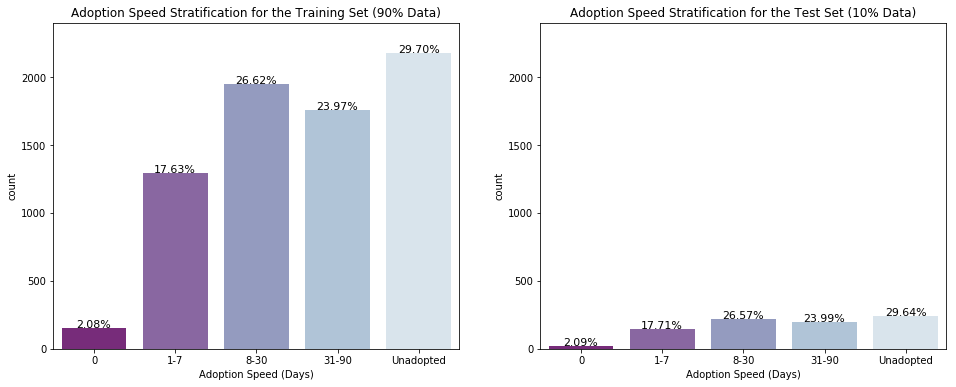

In [9]:
#Define x-axis labels
adpt_spd = adptspeed.AdoptionSpeed

#Create Figure with 2 subplots
fig, ax = plt.subplots(figsize = (16, 6))

#Plot stratification of training set
plt.subplot(1, 2, 1)
c = sns.countplot(x='AdoptionSpeed', data=dtrain, palette= 'BuPu_r')
plt.xticks([0,1,2,3,4], adpt_spd) 
plt.ylim([0,2400])
plt.xlabel('Adoption Speed (Days)')
plt.title ('Adoption Speed Stratification for the Training Set (90% Data)')

#Percentages above training set 
ax=c.axes
for p in ax.patches:
     ax.annotate(f"{p.get_height() * 100 / dtrain.shape[0]:.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=11, color='k', rotation=0, xytext=(0, 4),
         textcoords='offset points')

#Plot stratification of test set 
plt.subplot(1, 2, 2)

c = sns.countplot(x='AdoptionSpeed', data=dtest, palette= 'BuPu_r')
plt.xticks([0,1,2,3,4], adpt_spd) 
plt.ylim([0,2400])
plt.xlabel('Adoption Speed (Days)')
plt.title ('Adoption Speed Stratification for the Test Set (10% Data)')

#Percentages above test set 
ax=c.axes
for p in ax.patches:
     ax.annotate(f"{p.get_height() * 100 / dtest.shape[0]:.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=11, color='k', rotation=0, xytext=(0, 4),
         textcoords='offset points')

plt.show()

For some model development, specific features will be chosen to test initially for speed purposes. These features will be chosen based on the results of the Statistical Data Analysis previously completed ([GitHub Link Here](https://github.com/CJEJansson/Springboard_Projects/tree/master/Capstone%201/3.%20Statistical_Data_Analysis)). These models will then be tested using the entirety of the dataset to determine if it performs better or worse having access to all features. 


In [10]:
#Second Split to allow for model development testing
x, y = dtrain.loc[:, dtrain.columns != 'AdoptionSpeed'], dtrain['AdoptionSpeed']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1, stratify=y)

Due to the distribution of the data it may also be beneficial to drop the adoption speed of same day (category 0), and see if this is better for fitting the data, since such a small percentage (5.4%) are adopted same day. 

In [11]:
#Alternative test train split without the adoption speed = 0 to see if modeling is better
data_alt = data[data['AdoptionSpeed']!= 0.0]

#First Split to save 10% of Data
dtrain_alt, dtest_alt = train_test_split(data_alt, test_size = 0.1,stratify=data_alt['AdoptionSpeed'])

#Second Split to allow for model development testing
x_a, y_a = dtrain_alt.loc[:, dtrain_alt.columns != 'AdoptionSpeed'], dtrain_alt['AdoptionSpeed']

xa_train, xa_test, ya_train, ya_test = train_test_split(x_a, y_a, test_size=0.25, random_state=1, stratify=y_a)


In [12]:
#Create end test set variables 
x_all, y_all = dtrain.loc[:, dtrain.columns != 'AdoptionSpeed'], dtrain['AdoptionSpeed']
x_test_all, y_test_all = dtest.loc[:, dtest.columns != 'AdoptionSpeed'], dtest['AdoptionSpeed']

In [13]:
#Create end test set variables with no same day adoptions
x_a_all, y_a_all = dtrain_alt.loc[:, dtrain_alt.columns != 'AdoptionSpeed'], dtrain_alt['AdoptionSpeed']
x_atest_all, y_atest_all = dtest_alt.loc[:, dtest_alt.columns != 'AdoptionSpeed'], dtest_alt['AdoptionSpeed']

### Useful Functions for Analysis

In [14]:
#Create a function to plot confusion matrix as a heatmap
#given the confusion matrix, xticklabels, yticklabels, and plot title 

#Define axis labels for heatmaps
#All Dogs
adpt_spd = adptspeed.AdoptionSpeed
#No Same Day Adoption Dogs
adpt_spd_ns = adptspeed.AdoptionSpeed[1:]

def cm_plot(cm_arg , xt_label, yt_label, plt_title):
    
    """Plot Confusion Matrix for Model as a seaborne heat map
            arguments (cm_arg, xt_label, yt_label, plt_title)
            cm- confusion matrix to plot
            xt_label, yt_label - tickmark labels
            plt_title - plot title"""  
    
    ax = sns.heatmap(cm_arg, annot=True, fmt='g', xticklabels = xt_label, yticklabels = yt_label, linewidths = 3)
    ax.set (title = plt_title,
           xlabel = 'Adoption Speed (Days)',
           ylabel = 'Adoption Speed (Days)')
    plt.yticks(rotation = 0)

    return;


In [364]:
#Function to send confusion matrix identity matrix to dataframe for analysis with all data

#Define Empty Dataframe for all values
CMColumns = ['Same Day', '1-7', '8-30', '31-90', 'Unadopted']
all_data_CMS = pd.DataFrame (index = CMColumns)

def matrix_to_frame_all (matrix, model):
    """Convert the identity matrix of a confusion matrix to a string
         Takes the arguments matrix and model. matrix is the confusion matrix name
         model is the string name you want assigned as the ML model used
         Used for instances when confusion matrix contains all data"""
    #matrx = confusion matrix, model = name of machine learning model applied
    
    #Pull out identity matrix (True Positives/True Negatives)
    intcount = [0,1,2,3,4]
    ident_matrix_string = []
    cm_DF = pd.DataFrame((matrix/np.sum(matrix)*100))
    
    for i in intcount:
        value = cm_DF.loc[i,i]
        ident_matrix_string.append(value)
    
    all_data_CMS[model] = ident_matrix_string
    
    return;  

In [363]:
#Function to send confusion matrix identity matrix to dataframe for dogs excluding same day adoption data

#Define Empty Dataframe for all values
CMColumns_ns = ['1-7', '8-30', '31-90', 'Unadopted']
nosame_data_CMS = pd.DataFrame (index = CMColumns_ns)

def matrix_to_frame_NS (matrix, model):
    """Convert the identity matrix of a confusion matrix to a string"""
    """ Takes the arguments matrix and model. matrix is the confusion matrix name"""
    """ model is the string name you want assigned as the ML model used """
    """This function is used for instances when the confusion matrix contains no same day adoption data"""
    #matrx = confusion matrix, model = name of machine learning model applied
    
    #Pull out identity matrix (True Positives/True Negatives)
    intcount = [0,1,2,3,]
    ident_matrix_string = []
    cm_DF = pd.DataFrame((matrix/np.sum(matrix)*100))
    
    for i in intcount:
        value = cm_DF.loc[i,i]
        ident_matrix_string.append(value)
    
    nosame_data_CMS[model] = ident_matrix_string
    
    return;  

## Logistic Regression

It's time to choose some Machine Learning models to apply to this data set. 

Application of a regression model may not yield great results, because several of the variables have non-linear relationships. However, it doesn't hurt to verify this. It's also entirely possible that a combination model using regression may prove useful. 

The model will be built by further splitting the test set, to ensure that the initial train data set doesn't lead to overfitting.  

Initial tests will be run on only the variables with highest correlation, and then a final run will be repeated with the full dataset for final accuracy score.

In [147]:
logRegr = LogisticRegression(solver = 'lbfgs', multi_class = 'auto', max_iter = 10000)

#Test the model on the highest correlated features 
xlr, xtestlr, ylr, ytestlr = train_test_split(dtrain[['RescuerInt','Breed1','Age','PhotoAmt']], 
                                              np.ravel(dtrain[['AdoptionSpeed']],order='C'),
                                              stratify=dtrain['AdoptionSpeed'], 
                                              test_size=0.2,random_state=42)

#Train Model on the Data
logRegr.fit(xlr, ylr)
#Print Accuracy
print(accuracy_score(logRegr.predict(xtestlr), ytestlr))

0.37841530054644806


While this would be a typically unacceptable score, according to the leaderboard on Kaggle, the highest accuracy model created had an accuracy score of approximately 0.45338. So this is not terrible, but could be better. Let's explore different solver options for the model and see if one is a better choice than the others before we apply this model to the entire set of features. 


In [150]:
#create model instance
logRegr1 = LogisticRegression(solver='newton-cg',multi_class='ovr',max_iter=900000000)
#Test the model on Rescuer ID, age, and breed 
xlr, xtestlr, ylr, ytestlr = train_test_split(dtrain[['RescuerInt','Breed1','Age','PhotoAmt']], 
                                              np.ravel(dtrain[['AdoptionSpeed']],order='C'),
                                              stratify=dtrain['AdoptionSpeed'], 
                                              test_size=0.2,random_state=42)

#Train Model on the Data
logRegr1.fit(xlr, ylr)
#Print Accuracy
print(accuracy_score(logRegr1.predict(xtestlr), ytestlr))

0.3743169398907104


Because of the very large number of maximum interations necessary to ensure convergence, so this would not be an ideal choice for our model, and the score is the same as the default solver. 

In [15]:
#create model instance
logRegr2 = LogisticRegression(solver='liblinear',multi_class='ovr')
#Test the model on Rescuer ID, age, and breed 
xlr, xtestlr, ylr, ytestlr = train_test_split(dtrain[['RescuerInt','Breed1','Age','PhotoAmt']], 
                                              np.ravel(dtrain[['AdoptionSpeed']],order='C'),
                                              stratify=dtrain['AdoptionSpeed'], 
                                              test_size=0.2,random_state=42)

#Train Model on the Data
logRegr2.fit(xlr, ylr)
#Print Accuracy
print(accuracy_score(logRegr2.predict(xtestlr), ytestlr))

0.3941256830601093


In [152]:
#create model instance
logRegr3 = LogisticRegression(solver='saga',multi_class='ovr',max_iter=1000000)
#Test the model on Rescuer ID, age, and breed 
xlr, xtestlr, ylr, ytestlr = train_test_split(dtrain[['RescuerInt','Breed1','Age','PhotoAmt']], 
                                              np.ravel(dtrain[['AdoptionSpeed']],order='C'),
                                              stratify=dtrain['AdoptionSpeed'], 
                                              test_size=0.2,random_state=42)

#Train Model on the Data
logRegr3.fit(xlr, ylr)
#Print Accuracy
print(accuracy_score(logRegr3.predict(xtestlr), ytestlr))

0.3640710382513661


So it looks like the best choices for logistic regression is the either the default or the liblinear solver. Even using these choices an improved model will be needed, so let's explore some other options. 

Before moving on to a new model, let's try optimizing the one we're working with by optimizing the C parameter.

K-fold cross validation was deliberatly not utilized here because of the imbalanced classifications and the small number of data points in some groups as compared to others, which would likely lead to accuracy errors. 

In [21]:
#Test the model on Rescuer ID, age, and breed 
xlr, xtestlr, ylr, ytestlr = train_test_split(dtrain[['RescuerInt','Breed1','Age','PhotoAmt']], 
                                              np.ravel(dtrain[['AdoptionSpeed']],order='C'),
                                              stratify=dtrain['AdoptionSpeed'], 
                                              test_size=0.2,random_state=42)

#the grid of parameters to search over
Cs = [0.001, 0.1, 1, 10, 100]

# your turn
C_scores=[]

for param in Cs:
    clf = LogisticRegression(C=param,solver='liblinear',multi_class='ovr')
    fit = clf.fit(xlr,ylr)
    score = accuracy_score(clf.predict(xtestlr), ytestlr)
    C_scores.append(score)

max_score = max(C_scores)
max_idx = C_scores.index(max(C_scores))
highest_C = Cs[max_idx]

print('C Score Values: ' , C_scores)
print("Best score: ", max_score)
print("C value that yields best score =", highest_C)

C Score Values:  [0.36885245901639346, 0.383879781420765, 0.3866120218579235, 0.3859289617486339, 0.3859289617486339]
Best score:  0.3866120218579235
C value that yields best score = 1


In [20]:
#the grid of parameters to search over
Cs = [0.001, 0.1, 1, 10, 100]

# initialize an empty array 
C_scores=[]

#Run model over each C value in Cs
for param in Cs:
    clf = LogisticRegression(C=param,solver='lbfgs',multi_class='ovr')
    fit = clf.fit(xlr,ylr)
    score = accuracy_score(clf.predict(xtestlr), ytestlr)
    C_scores.append(score)

max_score = max(C_scores)
max_idx = C_scores.index(max(C_scores))
highest_C = Cs[max_idx]

print('C Score Values: ' , C_scores)
print("Best score: ", max_score)
print("C value that yields best score =", highest_C)

C Score Values:  [0.38046448087431695, 0.39207650273224043, 0.39207650273224043, 0.39207650273224043, 0.39207650273224043]
Best score:  0.39207650273224043
C value that yields best score = 0.1


Testing on both the solvers, it looks like the lbfgs gives a slightly better score when optimizing C value. Both scores are improved by tuning the hyperparameter C. Previous work on this yielded the same result between both solvers, so additional exploration will be continued with both. 

Let's take a quick look at the confusion matrices for both models before moving on. 

(array([0.5, 1.5, 2.5, 3.5, 4.5]), <a list of 5 Text yticklabel objects>)

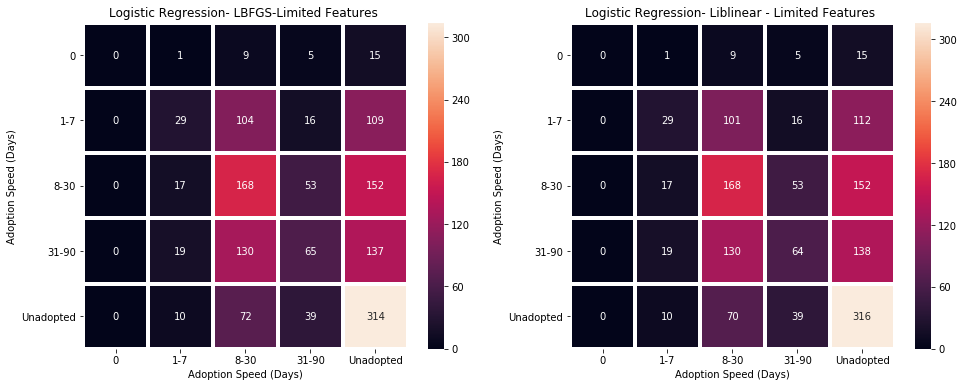

In [16]:
#Test the model on Rescuer ID, age, and breed 
xlr, xtestlr, ylr, ytestlr = train_test_split(dtrain[['RescuerInt','Breed1','Age','PhotoAmt']], 
                                              np.ravel(dtrain[['AdoptionSpeed']],order='C'),
                                              stratify=dtrain['AdoptionSpeed'], 
                                              test_size=0.2,random_state=42)

logRegrA = LogisticRegression(C= 0.1,solver='lbfgs',multi_class='ovr', max_iter=10000)
logRegAf = logRegrA.fit(xlr, ylr)
y_predA = logRegrA.predict(xtestlr)
cm_A = confusion_matrix(ytestlr,y_predA)

logRegrB = LogisticRegression(C=1,solver='liblinear',multi_class='ovr')
logRegBf = logRegrB.fit(xlr, ylr)
y_predB = logRegrB.predict(xtestlr)
cm_B = confusion_matrix(ytestlr,y_predB)

#import Labels for heatmaps
adpt_spd = adptspeed.AdoptionSpeed

#Create Figure with 2 subplots
fig, ax = plt.subplots(figsize = (16, 6))

#Plot Confusion matrix of LBFGS model
plt.subplot(1, 2, 1)
ax = sns.heatmap(cm_A, annot=True, fmt='g', xticklabels = adpt_spd, yticklabels = adpt_spd, linewidths = 3)
ax.set(title = 'Logistic Regression- LBFGS-Limited Features ',
      xlabel = 'Adoption Speed (Days)',
      ylabel = 'Adoption Speed (Days)')
plt.yticks(rotation = 0)


#Plot Confusion matrix of Liblinear model
plt.subplot(1, 2, 2)
ax = sns.heatmap(cm_B, annot=True, fmt='g', xticklabels = adpt_spd, yticklabels = adpt_spd, linewidths = 3)
ax.set(title = 'Logistic Regression- Liblinear - Limited Features ',
      xlabel = 'Adoption Speed (Days)',
      ylabel = 'Adoption Speed (Days)')
plt.yticks(rotation = 0)


Let's now perform testing using both the liblinear and the default (lbfgs) solvers and access to all the features in the data set to see if the score can be further improved. Then hypertune the parameters to see if we get the same results for C. 

In [24]:
#Run with a General model

logRegr2.fit(x_train, y_train)
#Print Accuracy
print('Logistic Regression, all features', accuracy_score(logRegr2.predict(x_test), y_test))

Logistic Regression, all features 0.36721311475409835


In [25]:
#Hypertune the parameters off the general model to see if score can be improved 

#the grid of parameters to search over
Cs = [0.001, 0.1, 1, 10, 100]

# initialize an empty array 
C_scores=[]

#Run model over each C value in Cs
for param in Cs:
    clf = LogisticRegression(C=param,solver='lbfgs',multi_class='ovr', max_iter=10000)
    fit = clf.fit(x_train,y_train)
    score = accuracy_score(clf.predict(x_test), y_test)
    C_scores.append(score)

max_score = max(C_scores)
max_idx = C_scores.index(max(C_scores))
highest_C = Cs[max_idx]

print('C Score Values: ' , C_scores)
print("Best score: ", max_score)
print("C value that yields best score =", highest_C)

C Score Values:  [0.3797814207650273, 0.3825136612021858, 0.3830601092896175, 0.38579234972677595, 0.37923497267759565]
Best score:  0.38579234972677595
C value that yields best score = 10


In [26]:
#the grid of parameters to search over
Cs = [0.001, 0.1, 1, 10, 100]

# initialize an empty array 
C_scores=[]

#Run model over each C value in Cs
for param in Cs:
    clf = LogisticRegression(C=param,solver='liblinear',multi_class='ovr')
    fit = clf.fit(x_train,y_train)
    score = accuracy_score(clf.predict(x_test), y_test)
    C_scores.append(score)

max_score = max(C_scores)
max_idx = C_scores.index(max(C_scores))
highest_C = Cs[max_idx]

print('C Score Values: ' , C_scores)
print("Best score: ", max_score)
print("C value that yields best score =", highest_C)

C Score Values:  [0.3846994535519126, 0.38524590163934425, 0.3846994535519126, 0.3846994535519126, 0.38579234972677595]
Best score:  0.38579234972677595
C value that yields best score = 100


So when running this on all the data the models actually converge and yield the same score, but with different C scores. The C-scores here are also different than those used when checking only certain paramters. It might be useful to see how the model predictions are disributed so let's pursue that before moving on to another model. 

(array([0.5, 1.5, 2.5, 3.5, 4.5]), <a list of 5 Text yticklabel objects>)

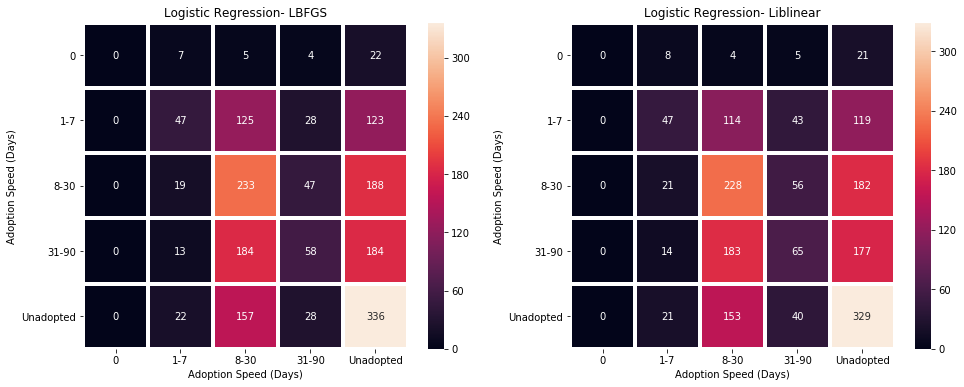

In [44]:
logRegrA = LogisticRegression(C= 1,solver='lbfgs',multi_class='ovr', max_iter=10000)
logRegAf = logRegrA.fit(x_all, y_all)
y_predA = logRegrA.predict(x_test_all)
cm_A = confusion_matrix(y_test_all,y_predA)

logRegrB = LogisticRegression(C=0.001,solver='liblinear',multi_class='ovr')
logRegBf = logRegrB.fit(x_all, y_all)
y_predB = logRegrB.predict(x_test_all)
cm_B = confusion_matrix(y_test_all,y_pred)

#import Labels for heatmaps
adpt_spd = adptspeed.AdoptionSpeed

#Create Figure with 2 subplots
fig, ax = plt.subplots(figsize = (16, 6))

#Plot Confusion matrix of LBFGS model
plt.subplot(1, 2, 1)
ax = sns.heatmap(cm_A, annot=True, fmt='g', xticklabels = adpt_spd, yticklabels = adpt_spd, linewidths = 3)
ax.set(title = 'Logistic Regression- LBFGS',
      xlabel = 'Adoption Speed (Days)',
      ylabel = 'Adoption Speed (Days)')
plt.yticks(rotation = 0)


#Plot Confusion matrix of Liblinear model
plt.subplot(1, 2, 2)
ax = sns.heatmap(cm_B, annot=True, fmt='g', xticklabels = adpt_spd, yticklabels = adpt_spd, linewidths = 3)
ax.set(title = 'Logistic Regression- Liblinear',
      xlabel = 'Adoption Speed (Days)',
      ylabel = 'Adoption Speed (Days)')
plt.yticks(rotation = 0)

So it looks like neither model is mapping same day adoptions very well, which is consistent with how rescues understand dog adoptions. Prediting which animals will go same-day as listing is very difficult and is often times just random luck. It's interesting that the model reveals that. 

Let's try one more analysis to see if removing the adoption speed classification for same day adoptions improves any of the model performance.

In [90]:
logRegr2.fit(xa_train, ya_train)
#Print Accuracy
print('Logistic Regression, all features, no same day adoption', accuracy_score(logRegr2.predict(xa_test), ya_test))

Logistic Regression, all features, no same day adoption 0.40424343941931884


Since there is definite improvement, let's perform the same process as above, with both restricted and all features to see what the best fit is. 

In [102]:
#Test the model on Rescuer ID, age, and breed 
xlr, xtestlr, ylr, ytestlr = train_test_split(dtrain_alt[['RescuerInt','Breed1','Age','PhotoAmt']], 
                                              np.ravel(dtrain_alt[['AdoptionSpeed']],order='C'),
                                              stratify=dtrain_alt['AdoptionSpeed'], 
                                              test_size=0.2,random_state=42)

#the grid of parameters to search over
Cs = [0.001, 0.1, 1, 10, 100]

# your turn
C_scores=[]

for param in Cs:
    clf = LogisticRegression(C=param,solver='liblinear',multi_class='ovr')
    fit = clf.fit(xlr,ylr)
    score = accuracy_score(clf.predict(xtestlr), ytestlr)
    C_scores.append(score)

max_score = max(C_scores)
max_idx = C_scores.index(max(C_scores))
highest_C = Cs[max_idx]

print('C Score Values: ' , C_scores)
print("Best score: ", max_score)
print("C value that yields best score =", highest_C)


C Score Values:  [0.3831123517096999, 0.40404745289602234, 0.40753663642707605, 0.4033496161898116, 0.4033496161898116]
Best score:  0.40753663642707605
C value that yields best score = 1


In [103]:
#the grid of parameters to search over
Cs = [0.001, 0.1, 1, 10, 100]

# initialize an empty array 
C_scores=[]

#Run model over each C value in Cs
for param in Cs:
    clf = LogisticRegression(C=param,solver='lbfgs',multi_class='ovr')
    fit = clf.fit(xr,ylr)
    score = accuracy_score(clf.predict(xtestlr), ytestlr)
    C_scores.append(score)

max_score = max(C_scores)
max_idx = C_scores.index(max(C_scores))
highest_C = Cs[max_idx]

print('C Score Values: ' , C_scores)
print("Best score: ", max_score)
print("C value that yields best score =", highest_C)

C Score Values:  [0.4019539427773901, 0.4026517794836008, 0.4026517794836008, 0.4026517794836008, 0.4026517794836008]
Best score:  0.4026517794836008
C value that yields best score = 0.1


(array([0.5, 1.5, 2.5, 3.5]), <a list of 4 Text yticklabel objects>)

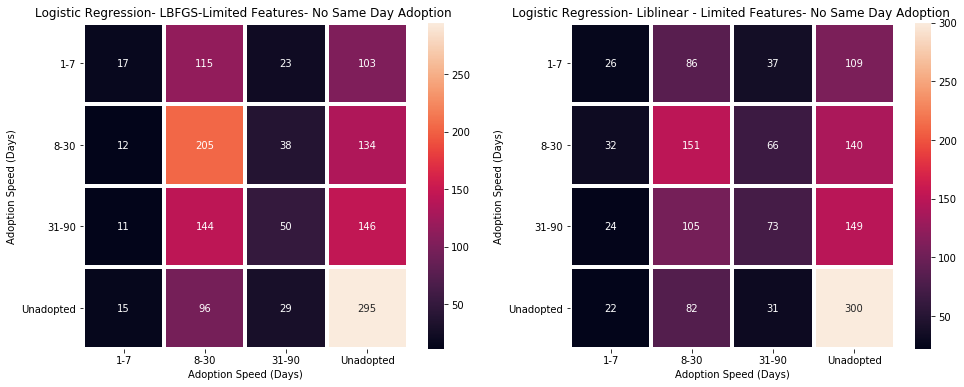

In [153]:
#Test the model on Rescuer ID, age, and breed 
xlr, xtestlr, ylr, ytestlr = train_test_split(dtrain_alt[['RescuerInt','Breed1','Age','PhotoAmt']], 
                                              np.ravel(dtrain_alt[['AdoptionSpeed']],order='C'),
                                              stratify=dtrain_alt['AdoptionSpeed'], 
                                              test_size=0.2,random_state=42)

logRegrA = LogisticRegression(C= 0.1,solver='lbfgs',multi_class='ovr', max_iter=10000)
logRegAf = logRegrA.fit(xlr, ylr)
y_predA = logRegrA.predict(xtestlr)
cm_A = confusion_matrix(ytestlr,y_predA)

logRegrB = LogisticRegression(C=1,solver='liblinear',multi_class='ovr')
logRegBf = logRegrB.fit(xlr, ylr)
y_predB = logRegrB.predict(xtestlr)
cm_B = confusion_matrix(ytestlr,y_predB)

#import Labels for heatmaps
adpt_spd = adptspeed.AdoptionSpeed[1:]

#Create Figure with 2 subplots
fig, ax = plt.subplots(figsize = (16, 6))

#Plot Confusion matrix of LBFGS model
plt.subplot(1, 2, 1)
ax = sns.heatmap(cm_A, annot=True, fmt='g', xticklabels = adpt_spd, yticklabels = adpt_spd, linewidths = 3)
ax.set(title = 'Logistic Regression- LBFGS-Limited Features- No Same Day Adoption ',
      xlabel = 'Adoption Speed (Days)',
      ylabel = 'Adoption Speed (Days)')
plt.yticks(rotation = 0)


#Plot Confusion matrix of Liblinear model
plt.subplot(1, 2, 2)
ax = sns.heatmap(cm_B, annot=True, fmt='g', xticklabels = adpt_spd, yticklabels = adpt_spd, linewidths = 3)
ax.set(title = 'Logistic Regression- Liblinear - Limited Features- No Same Day Adoption ',
      xlabel = 'Adoption Speed (Days)',
      ylabel = 'Adoption Speed (Days)')
plt.yticks(rotation = 0)

In [91]:
#the grid of parameters to search over
Cs = [0.001, 0.1, 1, 10, 100]

# initialize an empty array 
C_scores=[]

#Run model over each C value in Cs
for param in Cs:
    clf = LogisticRegression(C=param,solver='lbfgs',multi_class='ovr', max_iter=10000)
    fit = clf.fit(xa_train,ya_train)
    score = accuracy_score(clf.predict(xa_test), ya_test)
    C_scores.append(score)

max_score = max(C_scores)
max_idx = C_scores.index(max(C_scores))
highest_C = Cs[max_idx]

print('C Score Values: ' , C_scores)
print("Best score: ", max_score)
print("C value that yields best score =", highest_C)

C Score Values:  [0.40480178671133443, 0.4154103852596315, 0.4075935231714126, 0.4137353433835846, 0.41429369067560023]
Best score:  0.4154103852596315
C value that yields best score = 0.1


In [92]:
#the grid of parameters to search over
Cs = [0.001, 0.1, 1, 10, 100]

# initialize an empty array 
C_scores=[]

#Run model over each C value in Cs
for param in Cs:
    clf = LogisticRegression(C=param,solver='liblinear',multi_class='ovr')
    fit = clf.fit(xa_train,ya_train)
    score = accuracy_score(clf.predict(xa_test), ya_test)
    C_scores.append(score)

max_score = max(C_scores)
max_idx = C_scores.index(max(C_scores))
highest_C = Cs[max_idx]

print('C Score Values: ' , C_scores)
print("Best score: ", max_score)
print("C value that yields best score =", highest_C)

C Score Values:  [0.4025683975432719, 0.4036850921273032, 0.400893355667225, 0.4025683975432719, 0.4020100502512563]
Best score:  0.4036850921273032
C value that yields best score = 0.1


There is an improvement if same day adoptions are removed. This is actually to be expected, since it's difficult to predict which dogs will be adopted same day for experienced rescuers as well. 

So the best model for linear regression is found using either an lbfgs or liblinear solver  Knowing that a large number of iterations is needed for the lbfgs solver to work on the whole model, it may be better to use the liblinear choice, simply for time constraint reasons. Both options will be considered when using the full data set to test the final model. 

The full feature analysis showed best results when using a liblinear model and a C-value of 100 on the full dataset. 

It appears the best model accuracy can be found by using only some features (Breed, Rescuer ID, Pet Age, and Number of photos) suggesting that the model is overfitting the data. This is fairly common in logistic regression models. When restricticting features, the best model was found to use the lbfgs solver, with a C-value of 0.1. 

A final anaysis with the full data set (including the data set aside for model testing) will be run to verify accuracy as compared to the results from "full feature" analysis to conclude. 

Removal of the 5% of dogs adopted on the same day as they were listed had no effect on the model. 

Results

| Model | Accuracy Score | C-Value | Solver| Features|
| --- | --- | --- | --- | --- |
|Logistic Regression| 0.39208 |0.1| lbfgs| Rescuer, Breed, Age, #Photos |
|Logistic Regression| 0.38661| 1.0 | liblinear | Rescuer, Breed, Age, #Photos |
|Logistic Regression| 0.38579 |10| lbfgs| All Features|
|Logistic Regression| 0.38579 |100| liblinear| All Features|
|Logistic Regression| 0.41541 |0.1| lbfgs| No Same Day Adoptions|
|Logistic Regression| 0.40369 |0.1| liblinear| No Same Day Adoptions|


Let's now test these models on the entire data set and see if the results are consistent with those found on the subset. 

In [53]:
#Logistic Regression only some Features
#Limit Features
xa_lim = x_all[['RescuerInt','Breed1','Age','PhotoAmt']]
xt_lim = x_test_all[['RescuerInt','Breed1','Age','PhotoAmt']]

#Create model
logRegrlim = LogisticRegression(C= 0.1,solver='lbfgs',multi_class='ovr', max_iter=10000)

#Fit Model
logReglimf = logRegrlim.fit(xa_lim, y_all)

#Confusion Matrix
y_predlim = logRegrlim.predict(xt_lim)
cm_A = confusion_matrix(y_test_all,y_predlim)

#Accuracy Score
accuracy_limLR = accuracy_score(logRegrlim.predict(xt_lim), y_test_all)

#Results
print('The Accuracy Score for Limited Features Logistic Regression using an LBFGS solver is', 
      round(accuracy_limLR,5))


The Accuracy Score for Limited Features Logistic Regression using an LBFGS solver is 0.37146


In [216]:
#Define, fit models and create confusion matrices, calculate accuracy
#LBFGS Model
logRegrA = LogisticRegression(C= 1,solver='lbfgs',multi_class='ovr', max_iter=10000)
logRegAf = logRegrA.fit(x_all, y_all)
y_predA = logRegrA.predict(x_test_all)
cm_A_all = confusion_matrix(y_test_all,y_predA)
acc_A_all = accuracy_score(logRegrA.predict(x_test_all), y_test_all)

#LibLinear Model
logRegrB = LogisticRegression(C=0.001,solver='liblinear',multi_class='ovr')
logRegBf = logRegrB.fit(x_all, y_all)
y_predB = logRegrB.predict(x_test_all)
cm_B_all = confusion_matrix(y_test_all,y_predB)
acc_B_all = accuracy_score(logRegrB.predict(x_test_all), y_test_all)
                           
print('The Accuracy Score for Logistic Regression using the LBFGS solver on the entire data set is',
      round(acc_A_all,5))
print('The Accuracy Score for Logistic Regression using the Liblinear solver on the entire data set is', 
      round(acc_B_all,5))

The Accuracy Score for Logistic Regression using the LBFGS solver on the entire data set is 0.39114
The Accuracy Score for Logistic Regression using the Liblinear solver on the entire data set is 0.39483


In [221]:
# Write confusion matrices to dataframe for later use
matrix_to_frame_all(cm_A_all, 'Logistic Regresion -LBFGS')
matrix_to_frame_all(cm_B_all, 'Logistic Regression, Liblinear')
all_data_CMS

,Logistic Regresion -LBFGS,"Logistic Regression, Liblinear"
Same Day,0.000000,0.000000
1-7,2.583026,2.829028
8-30,13.407134,13.530135
31-90,4.305043,4.305043
Unadopted,18.819188,18.819188


(array([0.5, 1.5, 2.5, 3.5, 4.5]), <a list of 5 Text yticklabel objects>)

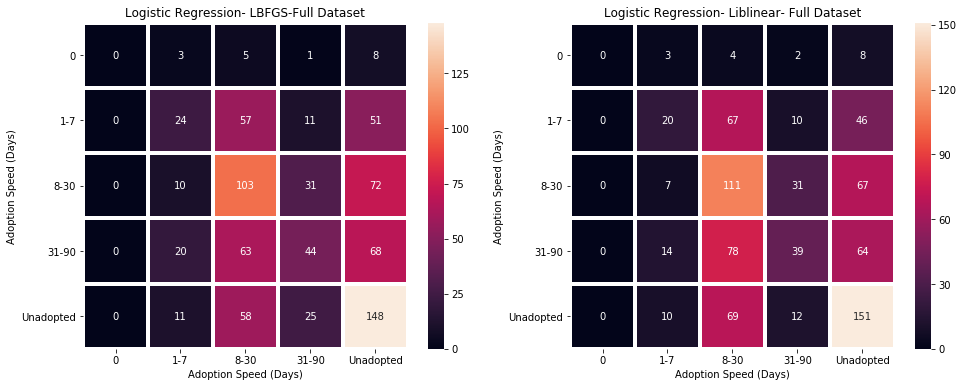

In [63]:
#import Labels for heatmaps
adpt_spd = adptspeed.AdoptionSpeed

#Create Figure with 2 subplots
fig, ax = plt.subplots(figsize = (16, 6))

#Plot Confusion matrix of LBFGS model
plt.subplot(1, 2, 1)
ax = sns.heatmap(cm_A_all, annot=True, fmt='g', xticklabels = adpt_spd, yticklabels = adpt_spd, linewidths = 3)
ax.set(title = 'Logistic Regression- LBFGS-Full Dataset',
      xlabel = 'Adoption Speed (Days)',
      ylabel = 'Adoption Speed (Days)')
plt.yticks(rotation = 0)


#Plot Confusion matrix of Liblinear model
plt.subplot(1, 2, 2)
ax = sns.heatmap(cm_B_all, annot=True, fmt='g', xticklabels = adpt_spd, yticklabels = adpt_spd, linewidths = 3)
ax.set(title = 'Logistic Regression- Liblinear- Full Dataset',
      xlabel = 'Adoption Speed (Days)',
      ylabel = 'Adoption Speed (Days)')
plt.yticks(rotation = 0)

Again, let's repeat for comparsion the above but for data without same-day adoptions. 

In [95]:
#Logistic Regression only some Features
#Limit Features
xa_lim = x_a_all[['RescuerInt','Breed1','Age','PhotoAmt']]
xt_lim = x_atest_all[['RescuerInt','Breed1','Age','PhotoAmt']]

#Create model
logRegrlim = LogisticRegression(C= 0.1,solver='lbfgs',multi_class='ovr', max_iter=10000)

#Fit Model
logReglimf = logRegrlim.fit(xa_lim, y_a_all)

#Confusion Matrix
y_predlim = logRegrlim.predict(xt_lim)
cm_A = confusion_matrix(y_atest_all,y_predlim)

#Accuracy Score
accuracy_limLR = accuracy_score(logRegrlim.predict(xt_lim), y_atest_all)

#Results
print('The Accuracy Score for Limited Features Logistic Regression using an', 'LBFGS solver and no same day adoptions is', 
      round(accuracy_limLR,5))

The Accuracy Score for Limited Features Logistic Regression using an LBFGS solver and no same day adoptions is 0.38645


In [222]:
#Define, fit models and create confusion matrices, calculate accuracy
#LBFGS Model
logRegrA = LogisticRegression(C= 0.1,solver='lbfgs',multi_class='ovr', max_iter=10000)
logRegAf = logRegrA.fit(x_a_all, y_a_all)
y_predA = logRegrA.predict(x_atest_all)
cm_A_all = confusion_matrix(y_atest_all,y_predA)
acc_A_all = accuracy_score(logRegrA.predict(x_atest_all), y_atest_all)

#LibLinear Model
logRegrB = LogisticRegression(C=0.1,solver='liblinear',multi_class='ovr')
logRegBf = logRegrB.fit(x_a_all, y_a_all)
y_predB = logRegrB.predict(x_atest_all)
cm_B_all = confusion_matrix(y_atest_all,y_predB)
acc_B_all = accuracy_score(logRegrB.predict(x_atest_all), y_atest_all)
                           
print('The Accuracy Score for Logistic Regression using the LBFGS solver on the entire data set with no same day adoptions is',
      round(acc_A_all,5))
print('The Accuracy Score for Logistic Regression using the Liblinear solver on the entire data set with no same day adoptions is', 
      round(acc_B_all,5))

The Accuracy Score for Logistic Regression using the LBFGS solver on the entire data set with no same day adoptions is 0.39147
The Accuracy Score for Logistic Regression using the Liblinear solver on the entire data set with no same day adoptions is 0.38896


In [243]:
# Write confusion matrices to dataframe for later use
matrix_to_frame_NS(cm_A_all, 'Logistic Regresion -LBFGS')
matrix_to_frame_NS(cm_B_all, 'Logistic Regression, Liblinear')
nosame_data_CMS

,Logistic Regresion -LBFGS,"Logistic Regression, Liblinear"
1-7,2.132999,2.007528
8-30,13.425345,13.174404
31-90,3.638645,3.387704
Unadopted,19.949812,20.326223


(array([0.5, 1.5, 2.5, 3.5]), <a list of 4 Text yticklabel objects>)

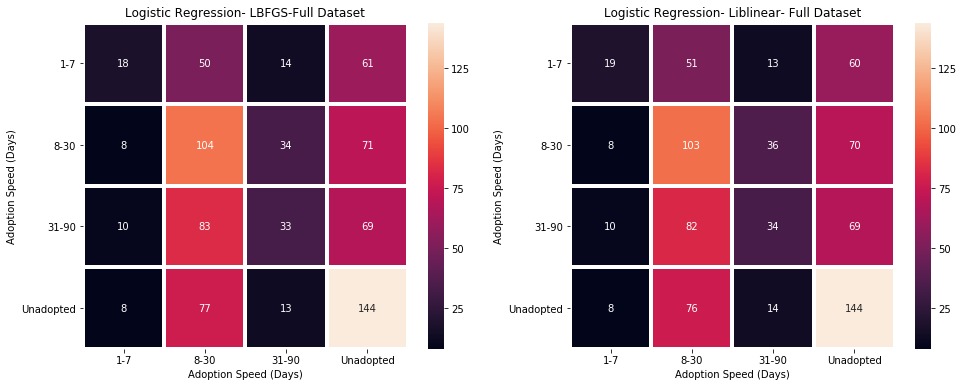

In [100]:
#import Labels for heatmaps
adpt_spd = adptspeed.AdoptionSpeed[1:]

#Create Figure with 2 subplots
fig, ax = plt.subplots(figsize = (16, 6))

#Plot Confusion matrix of LBFGS model
plt.subplot(1, 2, 1)
ax = sns.heatmap(cm_A_all, annot=True, fmt='g', xticklabels = adpt_spd, yticklabels = adpt_spd, linewidths = 3)
ax.set(title = 'Logistic Regression- LBFGS-Full Dataset',
      xlabel = 'Adoption Speed (Days)',
      ylabel = 'Adoption Speed (Days)')
plt.yticks(rotation = 0)


#Plot Confusion matrix of Liblinear model
plt.subplot(1, 2, 2)
ax = sns.heatmap(cm_B_all, annot=True, fmt='g', xticklabels = adpt_spd, yticklabels = adpt_spd, linewidths = 3)
ax.set(title = 'Logistic Regression- Liblinear- Full Dataset',
      xlabel = 'Adoption Speed (Days)',
      ylabel = 'Adoption Speed (Days)')
plt.yticks(rotation = 0)

#### Logistic Regression - Final thoughts 

Surprisingly, the liblinear model with access to all features and all pets fit best when testing all the data. 
This was unexpected, as the expected result was a highest score for All features with the not same day adoption pets. 

The confusion matrices for the analysis including the validation set show similar distributions, regardless of the model. 

It's suspected that increase in accuracy is due to the additional weight in the "unadopted" pets category, and not actually that the model is performing better. This is consistent with the fact that the final models without same-day adoption pets removed actually performed worse when tested using the entire dataset. 

Additional analysis into whether the model is overfitting would probably be wise, since the results seem to indicate this is what's occuring, but for now we'll move on to the next model. 

Final Scores: 

|Stage| Model | Accuracy Score | C-Value | Solver| Features|
| --- | --- | --- | --- | --- | ---|
|Development|Logistic Regression| 0.39208 |0.1| lbfgs| Rescuer, Breed, Age, #Photos |
|Development|Logistic Regression| 0.38661| 1.0 | liblinear | Rescuer, Breed, Age, #Photos |
|Development|Logistic Regression| 0.38579 |10| lbfgs| All Features|
|Development|Logistic Regression| 0.38579 |100| liblinear| All Features|
|Development|Logistic Regression|0.40754|1| lbfgs| No Same Day Adoptions, Some Features|
|Development|Logistic Regression|0.40265  |0.1| liblinear| No Same Day Adoptions, Some Features|
|Development|Logistic Regression| **0.41541** |0.1| lbfgs| No Same Day Adoptions, All Features|
|Development|Logistic Regression| 0.40369 |0.1| liblinear| No Same Day Adoptions, All Features|
||
|Final Test |Logistic Regression| 0.37146 |0.1| lbfgs| Rescuer, Breed, Age, #Photos |
|Final Test |Logistic Regression| 0.39237 |10| lbfgs| All Features|
|Final Test |Logistic Regression| **0.39483** |100| liblinear| All Features|
|Final Test |Logistic Regression| 0.38645 |0.1| lbfgs| Some Features, no same day adoptions|
|Final Test |Logistic Regression| 0.37516 |0.1| lbfgs| All Features, no same day adoptions|
|Final Test |Logistic Regression| 0.37641 |0.1| liblinear| All Features, no same day adoptions|



# Naive Bayes

Let's now try applying Naive Bayes.

Multinomial Naive Bayes will be used because the bulk of the data is categorical, and it tends to not be normally distributed. Gaussian was considered but because of the mix of variables, it was decided that the best choice would be multinomial. The benefit of using Naive Bayes is that it assumes the independence of each feature in the data set, and will hopefully find any instances where a particular feature has more weight than the others. This typically considered is one of the better intial choices for an "off the shelf" supervised learning algorithm, which is why it's being considered.

In [155]:
#Define the Model 
NBclf = MultinomialNB()

#Fit the Model 
NBclf_fit = NBclf.fit(x_train,y_train)

#Print results of score 
print ('Training Data Accuracy: ', NBclf_fit.score(x_train,y_train))
print ('Testing Data Accuracy:  ', NBclf_fit.score(x_test,y_test))

Training Data Accuracy:  0.2292691817022052
Testing Data Accuracy:   0.23879781420765028


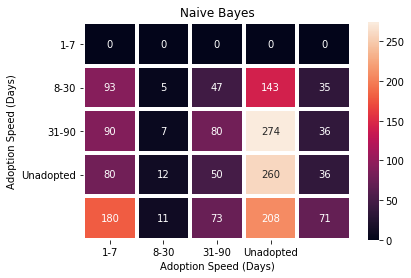

In [156]:
ya_pred = NBclf.predict(xa_test)
cm_NBa = confusion_matrix(ya_test,ya_pred)


#Plot Confusion matrix of Naive Bayes model
title = 'Naive Bayes'
cm_plot(cm_NBa, adpt_spd, adpt_spd, title)

This result is so much less accurate than the logistic regression model that it's probably not worth pursing hyperparameter tuning. The unforunate thing about this being that it is at least predicting with some accuracy those dogs that will be adopted same day. It is potentially this very feature that is causing the lack of accuracy, so let's try removing it and see if there's any improvement. 

In [158]:
# Repeat with adoption speed != 0 data 
NBclf_nozero = MultinomialNB()

#Fit the Model 
NBclf_nz_fit = NBclf_nozero.fit(xa_train,ya_train)

#Print results of score 
print ('Training Data Accuracy: ', NBclf_nz_fit.score(xa_train,ya_train))
print ('Testing Data Accuracy:  ', NBclf_nz_fit.score(xa_test,ya_test))

Training Data Accuracy:  0.3297971338172343
Testing Data Accuracy:   0.3294249022892239


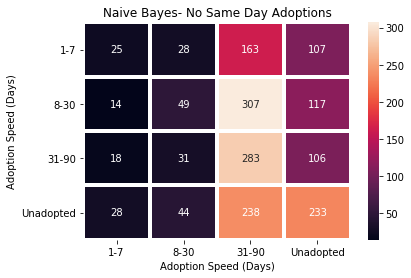

In [160]:
y_pred_ns = NBclf_nozero.predict(xa_test)
cm_NB_ns = confusion_matrix(ya_test,y_pred_ns)

#Create Confusion Matrix
title = 'Naive Bayes- No Same Day Adoptions'
cm_plot(cm_NB_ns, adpt_spd_ns, adpt_spd_ns, title)


Since this is equivalent to the other models, we can try some hyperparameter tuning.

In [112]:
#the grid of parameters to search over
alphas = [0.001, 0.1, 1, 10, 100]

# initialize an empty array 
Alpha_scores=[]

#Run model over each C value in Cs
for param in alphas:
    clf = MultinomialNB(alpha=param)
    fit = clf.fit(xa_train,ya_train)
    score = accuracy_score(clf.predict(xa_test), ya_test)
    Alpha_scores.append(score)

max_score = max(Alpha_scores)
max_idx = Alpha_scores.index(max(Alpha_scores))
highest_Alpha = alphas[max_idx]

print('Alpha Score Values: ' , Alpha_scores)
print("Best score: ", max_score)
print("Alpha value that yields best score =", highest_Alpha)

Alpha Score Values:  [0.34003350083752093, 0.34003350083752093, 0.34003350083752093, 0.34003350083752093, 0.3394751535455053]
Best score:  0.34003350083752093
Alpha value that yields best score = 0.001


So it immediately becomes obvious that the "same day" adopted pets are causing an issue with the model accuracy. However, hyperparameter showed a decrease in model accuracy, so it is not worth pursuing further as it will likely cause more problems than it solves. 

Let's now test this model on the entire data set, again both with and without same day adoptions to see the results. 

Training Data Accuracy:  0.22577559108924422
Testing Data Accuracy:   0.23001230012300122


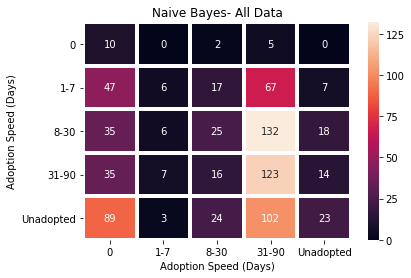

In [241]:
# Repeat with all data- including validation set 
NBclf = MultinomialNB()

#Fit the Model 
NBclf_fit = NBclf.fit(x_all,y_all)

#Print results of score 
print ('Training Data Accuracy: ', NBclf_fit.score(x_all,y_all))
print ('Testing Data Accuracy:  ', NBclf_fit.score(x_test_all,y_test_all))

y_pred = NBclf.predict(x_test_all)
cm_NB = confusion_matrix(y_test_all,y_pred)


#Plot Confusion matrix of Naive Bayes model
title = 'Naive Bayes- All Data'
cm_plot(cm_NB, adpt_spd, adpt_spd, title)

# Write confusion matrices to dataframe for later use
matrix_to_frame_all(cm_NB, 'Naive Bayes')


Training Data Accuracy:  0.3310999441652708
Testing Data Accuracy:   0.3212045169385194


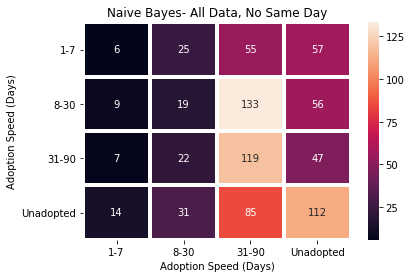

In [249]:
# Repeat with all data- including validation set- but no same day adoptions
NBclf_nz_2 = MultinomialNB()

#Fit the Model 
NBclf_nz2_fit = NBclf_nz_2.fit(x_a_all,y_a_all)

#Print results of score 
print ('Training Data Accuracy: ', NBclf_nz2_fit.score(x_a_all,y_a_all))
print ('Testing Data Accuracy:  ', NBclf_nz2_fit.score(x_atest_all,y_atest_all))

ya_pred = NBclf_nz_2.predict(x_atest_all)
cma_NB = confusion_matrix(y_atest_all,ya_pred)

#Plot Confusion matrix of Naive Bayes model
title = 'Naive Bayes- All Data, No Same Day'
cm_plot(cma_NB, adpt_spd_ns, adpt_spd_ns, title)

# Write confusion matrices to dataframe for later use
matrix_to_frame_NS(cma_NB, 'Naive Bayes')

#### Naive Bayes- Final Thoughts 

This model is most accurate when you remove the pets adopted same day. This is likely due to the independence considerations it makes. So while it makes it better than logistic regression for predicting same day adoptions, it is not as accurate overall. 
 

| Model | Accuracy Score | All Pets/No Same Day| 
| --- | --- | ---|
|Logistic Regression-liblinear | 0.39483| All Pets |
|Naive Bayes | 0.31242| No Same Day| 



# Support Vector Machines

Since Naive Bayes was successful, it would probably be beneficial to investigate further something that utilizes a categorization approach. We'll start with Linear SVC, since Logistic Regression analysis indicated there was some linearity in the data. Since this is a multiclass problem, SVC will be used instead of SVM. 

## Linear SVC

Linear SVC was explored first because it tends to be faster to converge than the SVC method. 

In [252]:
#Create the model
Lsvc = LinearSVC(random_state = 0, max_iter = 10000)

#Test model on data 
Lsvc.fit(x_train, y_train)

#Print results
print ('Linear SVC all features', Lsvc.score(x_test,y_test))

Linear SVC all features 0.2967213114754098


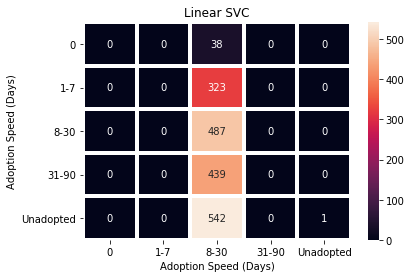

In [171]:
y_pred = Lsvc.predict(x_test)
cm_LSVC = confusion_matrix(y_test,y_pred)

#Plot Confusion matrix of LSVC model
title = 'Linear SVC'
cm_plot(cm_LSVC, adpt_spd, adpt_spd, title)


Yikes! This is by far the worst so far, but let's go ahead and apply it to the set of data without same-day adoption  and see if it does any better.

Linear SVC all features 0.27247347850362924


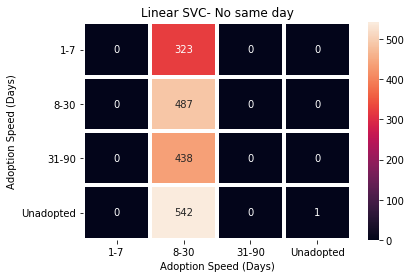

In [168]:
#Repeat for pets without same day adoption classification
Lsvc.fit(xa_train, ya_train)
print ('Linear SVC all features', Lsvc.score(xa_test,ya_test))

ya_pred = Lsvc.predict(xa_test)
cm_LSVC = confusion_matrix(ya_test,ya_pred)

#Plot Confusion matrix of LSVC model
title = 'Linear SVC- No same day'
cm_plot(cm_LSVC, adpt_spd_ns, adpt_spd_ns, title)

While this is better, its still pretty far off the accuracy of the other models, and the confusion matrix is showing that the classification of this model is not worth trying to tune the model any, let's move on to Nonlinear SVC. We'll wrap up by running a final analysis on the entire data set for both cases.

In [254]:
#Test model on all data 
Lsvc.fit(x_all, y_all)
print ('Linear SVC all data - validation set', Lsvc.score(x_test_all,y_test_all))
y_pred = Lsvc.predict(x_test_all)
cm_LSVC = confusion_matrix(y_test_all,y_pred)

#Repeat without same day adoption data
Lsvc.fit(x_a_all, y_a_all)
print ('Linear SVC no same day - validation set', Lsvc.score(x_atest_all,y_atest_all))
ya_pred = Lsvc.predict(x_atest_all)
cma_LSVC = confusion_matrix(y_atest_all,ya_pred)

Linear SVC all data - validation set 0.23985239852398524
Linear SVC no same day - validation set 0.27352572145545795


In [255]:
matrix_to_frame_all(cm_LSVC,' Linear SVC')
matrix_to_frame_NS (cma_LSVC, 'Linear SVC')

| Model | Accuracy Score | All Pets/No Same Day| 
| --- | --- | ---|
|Logistic Regression-liblinear | 0.39483| All Pets |
|Naive Bayes | 0.31242| No Same Day| 
|Linear SVC| 0.27527 | No Same Day | 


## Nonlinear SVC

Nonlinear SVC is likely going to be a better choice for this dataset, simply because it is smaller. Larger datasets tend to perform better with linear SVC, due to the one-vs-rest approach that linear SVC uses.

Since the default kernel here is rbf, it will also likely work better with the multiclass categorization of our dtaset. Utilizing a gamma of 'auto' will be more efficient because it both runs faster, and because it will work to correctly scale the amount of influence each single training example has. 

If the model proves to be a decent fit, we can tune it further using hyperparameters. 

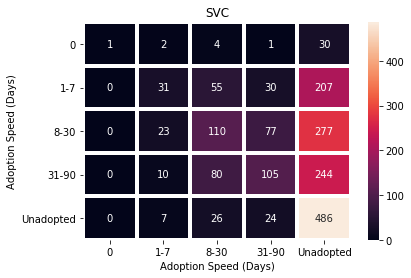

In [259]:
svclassifier = SVC(gamma='auto')

#All Features Analysis
svclassifier.fit(x_train, y_train)
y_pred = svclassifier.predict(x_test)
cm_SVC = confusion_matrix(y_test,y_pred)

#Plot Confusion matrix of SVC model
title = 'SVC'
cm_plot(cm_SVC, adpt_spd, adpt_spd, title)

In [175]:
#Return the classification report 
print(classification_report(y_test,y_pred))

#Return the accuracy score 
print('Accuracy Score', svclassifier.score(x_test,y_test))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        38
         1.0       0.43      0.10      0.17       323
         2.0       0.41      0.24      0.31       487
         3.0       0.37      0.15      0.21       439
         4.0       0.39      0.92      0.55       543

    accuracy                           0.39      1830
   macro avg       0.32      0.28      0.25      1830
weighted avg       0.39      0.39      0.32      1830

Accuracy Score 0.3907103825136612


This model shows more promise than the linearSVC model did, but it is again not mapping the same-day adoptions very well. Before removing those data points and reanalyzing, lets first try some hyperparameter tuning to see if the model can be further improved. Note that we are unable to use GridSearchCV because of the method of stratification used to separate and fold the samples. 

In [29]:
#the grid of parameters to search over
Cs = [0.001, 0.1, 1, 10, 100, 250]

# initialize an empty array 
C_scores = []

#Run model over each C value in Cs
for param in Cs:
    clf = SVC(gamma = 'auto', C = param)
    fit = clf.fit(xa_train,ya_train)
    score = accuracy_score(clf.predict(xa_test), ya_test)
    C_scores.append(score)

max_score = max(C_scores)
max_idx = C_scores.index(max(C_scores))
highest_C = Cs[max_idx]

print('C Score Values: ' , C_scores)
print("Best score: ", max_score)
print("C value that yields best score =", highest_C)

C Score Values:  [0.30318257956448913, 0.3137911781127862, 0.9530988274706867, 0.9899497487437185, 0.9966499162479062, 0.9966499162479062]
Best score:  0.9966499162479062
C value that yields best score = 100


So while the accuracy on this is greatly improved..... it's  definitely overfitting because of the huge difference in accuracy between test and train sets. This isn't worth pursuing, so let's instead continue with the base model and investigate data without same day adoptions, as well as the full data set.

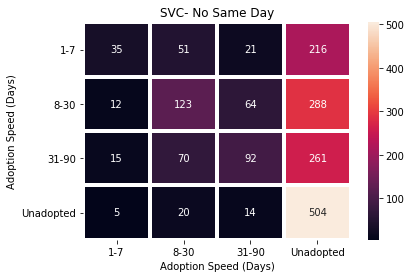

In [176]:
#Repeat without same day adoptions 
svclassifier = SVC(gamma='auto')

#All Features 
svclassifier.fit(xa_train, ya_train)
ya_pred = svclassifier.predict(xa_test)

cm_SVC = confusion_matrix(ya_test,ya_pred)

#Plot Confusion matrix of SVC model
title = 'SVC- No Same Day'
cm_plot(cm_SVC, adpt_spd_ns, adpt_spd_ns, title)

In [19]:
#Return the classification report 
print(classification_report(ya_test,ya_pred))

#Return the accuracy score 
print('Accuracy Score', svclassifier.score(xa_test,ya_test))

              precision    recall  f1-score   support

         1.0       0.52      0.11      0.18       323
         2.0       0.47      0.25      0.33       487
         3.0       0.48      0.21      0.29       438
         4.0       0.40      0.93      0.56       543

    accuracy                           0.42      1791
   macro avg       0.47      0.37      0.34      1791
weighted avg       0.46      0.42      0.36      1791

Accuracy Score 0.42099385817978785


Again, the score is improved by removing the same day adoptions, which is not unexpected as the model was not accurately predicting those to begin with. 

Let's take a final look at accuracy over the whole data set, including the validation data on both situations (all data, and data with no same day adoptions).

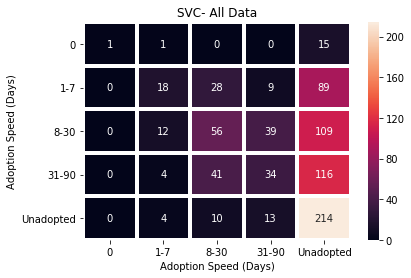

In [260]:
#All Features 
svclassifier.fit(x_all, y_all)
y_pred = svclassifier.predict(x_test_all)

cm_SVC = confusion_matrix(y_test_all,y_pred)

#Plot Confusion matrix of SVC model
title = 'SVC- All Data'
cm_plot(cm_SVC, adpt_spd, adpt_spd, title)

## Write confusion matrices to dataframe for later use
matrix_to_frame_all(cm_SVC, 'SVC')


In [178]:
#Return the classification report 
print(classification_report(y_test_all,y_pred))

#Return the accuracy score 
print('Accuracy Score', svclassifier.score(x_test_all,y_test_all))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        17
         1.0       0.50      0.12      0.20       144
         2.0       0.45      0.28      0.35       216
         3.0       0.43      0.21      0.28       195
         4.0       0.39      0.87      0.54       241

    accuracy                           0.41       813
   macro avg       0.35      0.30      0.27       813
weighted avg       0.42      0.41      0.35       813

Accuracy Score 0.4059040590405904


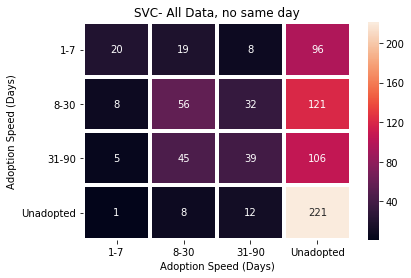

In [262]:
#Repeat again but with no same day adoptions
#All Features 
svclassifier.fit(x_a_all, y_a_all)
y_a_pred = svclassifier.predict(x_atest_all)

cm_SVC = confusion_matrix(y_atest_all,y_a_pred)

#Plot Confusion matrix of SVC model
title = 'SVC- All Data, no same day'
cm_plot(cm_SVC, adpt_spd_ns, adpt_spd_ns, title)

## Write confusion matrices to dataframe for later use
matrix_to_frame_NS(cm_SVC, 'SVC')

In [27]:
#Return the classification report 
print(classification_report(y_atest_all,y_a_pred))

#Return the accuracy score 
print('Accuracy Score', svclassifier.score(x_atest_all,y_atest_all))

              precision    recall  f1-score   support

         1.0       0.46      0.11      0.18       143
         2.0       0.49      0.31      0.38       217
         3.0       0.59      0.28      0.38       195
         4.0       0.41      0.90      0.56       242

    accuracy                           0.45       797
   macro avg       0.49      0.40      0.38       797
weighted avg       0.48      0.45      0.40       797

Accuracy Score 0.4466750313676286


So far this model performs the best of all the models. This is interesting, and is probably due to the way that gamma is being utilized to fit the shape of the Gaussian, which may be filtering out noise. 

| Model | Accuracy Score | All Pets/No Same Day| 
| --- | --- | ---|
|Logistic Regression-liblinear | 0.39483| All Pets |
|Naive Bayes | 0.31242| No Same Day| 
|Linear SVC| 0.27527 | No Same Day | 
|SVC | 0.44668 | No Same Day|

# K Nearest Neighbors

K-Nearest Neighbors (kNN) was chosen for exploration because it is a method that allows for investigation into both classification and regression problems, so perhaps it will be a good blend of all the previous models. The only concern prior to application is that the data set may be too large to analyze using this method, even though the decisions made through the analysis process allowed for some of the dataset to be eliminated, so let's first start with limited feature access, to be sure the model runs.

In [31]:
#Split Data
xtrain, xtest, ytrain, ytest = train_test_split(dtrain[['RescuerInt']], 
                                              np.ravel(dtrain[['AdoptionSpeed']],order='C'),
                                              stratify=dtrain['AdoptionSpeed'], 
                                              test_size=0.2,random_state=42)


kNN=KNeighborsClassifier()
kNN.fit(xtrain,ytrain)
print ('KNN Score Specific Features', kNN.score(xtest,ytest))


KNN Score Specific Features 0.3531420765027322


Since the model runs, let's go ahead and give it access to all features. 

KNN Score all features 0.3693989071038251


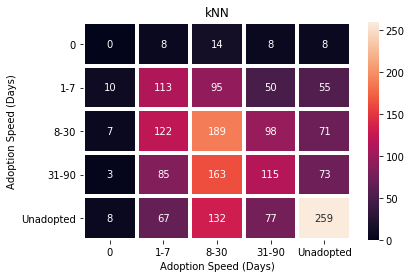

In [180]:
kNN.fit(x_train,y_train)
print ('KNN Score all features', kNN.score(x_test,y_test))
y_pred = kNN.predict(x_test)
cm_kNN = confusion_matrix(y_test,y_pred)

#Plot Confusion matrix of kNN model
title = 'kNN'
cm_plot(cm_kNN, adpt_spd, adpt_spd, title)

KNN Score Adoption Speeds Not Same Day 0.39475153545505304


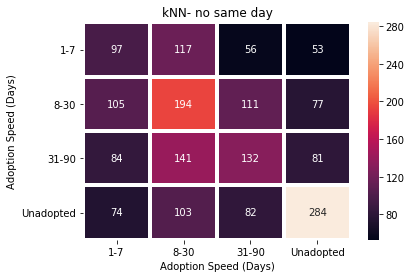

In [181]:
# Repeat for non same day adoptions 
kNN.fit(xa_train,ya_train)
print ('KNN Score Adoption Speeds Not Same Day', kNN.score(xa_test,ya_test))

ya_pred = kNN.predict(xa_test)
cma_kNN = confusion_matrix(ya_test,ya_pred)

#Plot Confusion matrix of kNN model
title = 'kNN- no same day'
cm_plot(cma_kNN, adpt_spd_ns, adpt_spd_ns, title)

These scores are pretty good as compared to the other models, lets try changing the algorithm being used and see if they can improved on any. We'll use the no same day adoption speed set, since it's a better fit. 

In [56]:
#iniitalize an empty array
knn_scores = []

#models to test
knn_model = ['auto', 'ball_tree', 'kd_tree', 'brute']

for model in knn_model:
    kNN_iter = KNeighborsClassifier(algorithm = model)
    fit = kNN_iter.fit(xa_train,ya_train)
    score = kNN_iter.score(xa_test,ya_test)
    knn_scores.append(score)
    
max_score = max(knn_scores)
max_idx = knn_scores.index(max(knn_scores))
best_fit = knn_model[max_idx]

print ('Scores', knn_scores)
print('Best Score', max_score, 'from', best_fit, 'algorithm.')
    

Scores [0.39307649357900615, 0.39475153545505304, 0.39307649357900615, 0.3969849246231156]
Best Score 0.3969849246231156 from brute algorithm.


Brute force is, unsurprisingly the best scorer here. This makes sense knowing that brute force looks at all datapoints before classifying. This approach is why the one-vs-all model in LinearSVC was expected to work. However, these are all decent scores compared to the previous models. So, let's go ahead and try manipulating the leaf size somem for the ball-tree and kd-tree methods to see if they can be further improved. It was hoped that these would perform slightly better because of how well the SVC model performed. Particularly since the ball-tree algorithm and SVC both use radial categorization algorithms, and so perhaps they would be closely related. Unsurprisingly, the KD-tree performed the worst, which is not unexpected knowing that the tree is axis-aligned and lack of flexibility when taking shape can lead to poor fits. 

In [74]:
leaves = [1, 5, 15, 30, 45, 60, 100]
leaf_scores_bt = []
leaf_scores_kt =[]

for leaf in leaves:
        #ball-tree
        
        kNN_bt = KNeighborsClassifier(algorithm = 'ball_tree', leaf_size = leaf)
        fit_bt = kNN_bt.fit(xa_train,ya_train)
        score_bt = kNN_bt.score(xa_test,ya_test)
        leaf_scores_bt.append(score_bt)
        
        #kd-tree
        kNN_kt = KNeighborsClassifier(algorithm = 'kd_tree', leaf_size = leaf)
        fit_kt = kNN_kt.fit(xa_train,ya_train)
        score_kt = kNN_bt.score(xa_test,ya_test)
        leaf_scores_kt.append(score)

        
max_score_bt, max_score_kt = max(leaf_scores_bt), max(leaf_scores_kt)
max_idx_bt, max_idx_kt = leaf_scores_bt.index(max(leaf_scores_bt)), leaf_scores_kt.index(max(leaf_scores_kt))
best_fit_bt, best_fit_kt = leaves[max_idx_bt], leaves[max_idx_kt]



#print ('Ball-Tree Scores', leaf_scores_bt)
#print ('KD-Tree Scores', leaf_scores_kt)
print('Best Score', max_score_bt, ', leaf size', best_fit_bt, 'with ball-tree algorithm.')
print('Best Score', max_score_kt, ', leaf size', best_fit_kt, 'with kd-tree algorithm.')
print ('vs Brute algorithm score: 0.3969849246231156')

Best Score 0.39586823003908433 , leaf size 45 with ball-tree algorithm.
Best Score 0.3969849246231156 , leaf size 1 with kd-tree algorithm.
vs Brute algorithm score: 0.3969849246231156


So since the brute algorithm score and the kt-tree score are the same when optimziing leaf size, we'll test the brute force algorith, as our final optiminzed kNN model. Again for all the data, and for the data without same-day adoptions.

KNN Score Adoption Speeds Not Same Day 0.3899138991389914


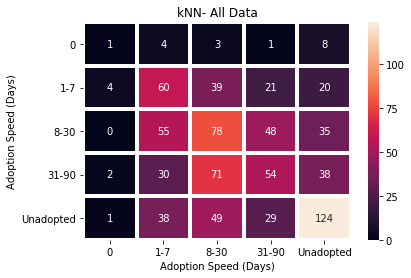

In [266]:
#All data with validation set 
kNN_iter = KNeighborsClassifier(algorithm = 'brute')

kNN_iter.fit(x_all,y_all)
print ('KNN Score Adoption Speeds Not Same Day', kNN_iter.score(x_test_all,y_test_all))

#Create and plot confusion matrix 
y_pred = kNN_iter.predict(x_test_all)
cm_kNN = confusion_matrix(y_test_all,y_pred)


#Plot Confusion matrix of kNN model
title = 'kNN- All Data'
cm_plot(cm_kNN, adpt_spd, adpt_spd, title)


# Write confusion matrices to dataframe for later use
matrix_to_frame_all(cm_kNN, 'kNN')


KNN Score Adoption Speeds Not Same Day 0.3989962358845671


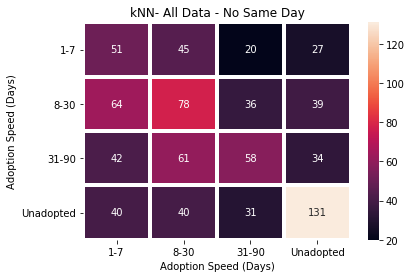

In [269]:
#No same day data with validation set 
kNN_iter = KNeighborsClassifier(algorithm = 'brute')

kNN_iter.fit(x_a_all,y_a_all)
print ('KNN Score Adoption Speeds Not Same Day', kNN_iter.score(x_atest_all,y_atest_all))

#Create and plot confusion matrix 
ya_pred = kNN_iter.predict(x_atest_all)
cma_kNN = confusion_matrix(y_atest_all,ya_pred)

#Plot Confusion matrix of kNN model
title = 'kNN- All Data - No Same Day'
cm_plot(cma_kNN, adpt_spd_ns, adpt_spd_ns, title) 

# Write confusion matrices to dataframe for later use
matrix_to_frame_NS(cma_kNN, 'kNN')

As with the other models, this model performs best if you remove the dogs adopted same day. 

Best performing algorithm is brute, or kd-tree with a leaf size of 1. 


| Model | Accuracy Score | All Pets/No Same Day| 
| --- | --- | ---|
|Logistic Regression-liblinear | 0.39483| All Pets |
|Naive Bayes | 0.31242| No Same Day| 
|Linear SVC| 0.27527 | No Same Day | 
|SVC | 0.44668 | No Same Day|
|kNN| 0.41656 | No Same Day |

# Random Forest 

It is now time to investigate ensemble methods to see how these perform. The first to explore is Random Forest. A classifier was chosen because we’re trying to predict a categorical response variable. 

Random Forest Score, all adoption speeds 0.40382513661202185


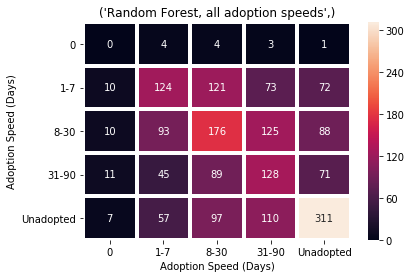

In [94]:
RF = RandomForestClassifier(random_state = 0, n_estimators = 10)

#Test model on all features
RF.fit(x_train, y_train)
y_pred = RF.predict(x_test)
cm_RF = confusion_matrix(y_pred, y_test)
print ('Random Forest Score, all adoption speeds', RF.score(x_test,y_test))

title1 = 'Random Forest, all adoption speeds',
cm_plot(cm_RF, adpt_spd, adpt_spd, title1)


Random Forest Score no same day adoption 0.4148520379676159


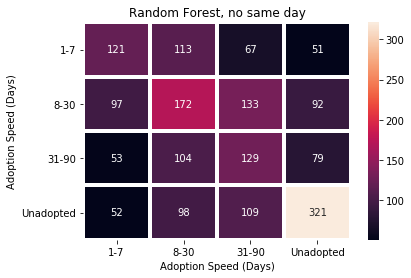

In [95]:
#Test model on adoption speeds other than same day
RF.fit(xa_train, ya_train)
ya_pred = RF.predict(xa_test)
cm_RF2 = confusion_matrix(ya_pred, ya_test)
print ('Random Forest Score no same day adoption', RF.score(xa_test,ya_test))



title2 = 'Random Forest, no same day'
cm_plot (cm_RF2, adpt_spd_ns, adpt_spd_ns, title2)

So far this is the best model, so it would likely be beneficial to pursue some hyperparameter tuning on the Random Forest Model. Consistent with the other models, it works best if you drop the same day adoption data. 
Let's investigate the performance when tuning n_estimators. 

In [98]:
#For all adoption speeds 
#the grid of parameters to search over
Ns = [1, 10, 50, 100, 110, 120, 130, 140, 150]

# initialize an empty array 
N_scores=[]

#Run model over each C value in Cs
for param in Ns:
    RF = RandomForestClassifier(random_state = 0, n_estimators = param)
    RF.fit(x_train, y_train)
    score = RF.score(x_test,y_test)
    N_scores.append(score)

max_score = max(N_scores)
max_idx = N_scores.index(max(N_scores))
highest_N = Ns[max_idx]

print('N-Estimators Values: ' , N_scores)
print("Best score: ", max_score)
print("N-estimator value that yields best score =", highest_N)

N-Estimators Values:  [0.3256830601092896, 0.40382513661202185, 0.45027322404371584, 0.4546448087431694, 0.45956284153005467, 0.4628415300546448, 0.4633879781420765, 0.46939890710382515, 0.4639344262295082]
Best score:  0.46939890710382515
N-estimator value that yields best score = 140


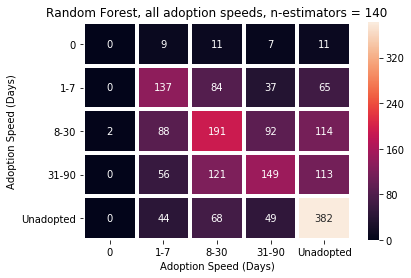

In [102]:
RF = RandomForestClassifier(random_state = 0, n_estimators = 140)
RF.fit(x_train,y_train)
y_pred = RF.predict(x_test)
cm_rf = confusion_matrix(y_test,y_pred)

title2 = 'Random Forest, all adoption speeds, n-estimators = 140'
cm_plot (cm_rf, adpt_spd, adpt_spd, title2)


In [106]:
#For same day adoptions only 
#the grid of parameters to search over
Ns = [1, 10, 50, 100, 150, 200, 250, 300]

# initialize an empty array 
N_scores=[]

#Run model over each C value in Cs
for param in Ns:
    RF = RandomForestClassifier(random_state = 0, n_estimators = param)
    RF.fit(xa_train, ya_train)
    score = RF.score(xa_test,ya_test)
    N_scores.append(score)

max_score = max(N_scores)
max_idx = N_scores.index(max(N_scores))
highest_N = Ns[max_idx]

print('N-Estimators Values: ' , N_scores)
print("Best score: ", max_score)
print("N-estimator value that yields best score =", highest_N)

N-Estimators Values:  [0.3629257398101619, 0.4148520379676159, 0.4701284198771636, 0.46621998883305416, 0.474036850921273, 0.47571189279731996, 0.4723618090452261, 0.47571189279731996]
Best score:  0.47571189279731996
N-estimator value that yields best score = 200


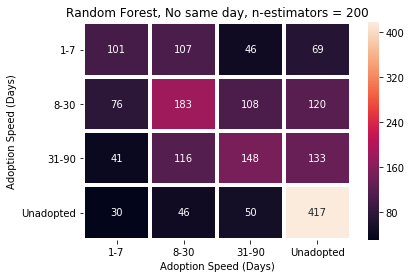

In [107]:
RF = RandomForestClassifier(random_state = 0, n_estimators = 150)
RF.fit(xa_train,ya_train)
ya_pred = RF.predict(xa_test)
cm_rfa = confusion_matrix(ya_test,ya_pred)


title = 'Random Forest, No same day, n-estimators = 200'
cm_plot (cm_rfa, adpt_spd_ns, adpt_spd_ns, title)

This is performing really well, let's see how performs across all data for each set (with and without same day adoptions) to determine if there is overfitting. 


Random Forest Score 0.46371463714637146


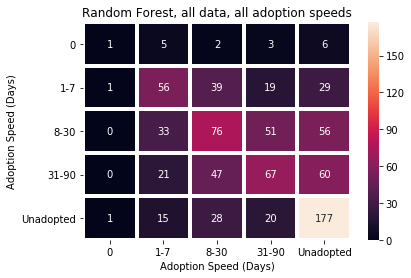

In [271]:
#All Animals 
RF = RandomForestClassifier(random_state = 0, n_estimators = 140)
RF.fit(x_all,y_all)
y_pred = RF.predict(x_test_all)
cm_rf = confusion_matrix(y_test_all,y_pred)
print ('Random Forest Score', RF.score(x_test_all,y_test_all))

title = 'Random Forest, all data, all adoption speeds'
cm_plot (cm_rf, adpt_spd, adpt_spd, title)

# Write confusion matrices to dataframe for later use
matrix_to_frame_all(cm_rf, 'Random Forest')


Random Forest Score 0.4780426599749059


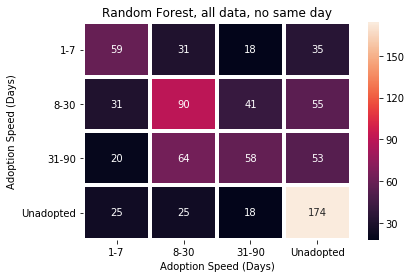

In [288]:
#No Same Day adoption speeds

RF = RandomForestClassifier(random_state = 0, n_estimators = 140)
RF.fit(x_a_all,y_a_all)
y_apred = RF.predict(x_atest_all)
cm_rf = confusion_matrix(y_atest_all,y_apred)
print ('Random Forest Score', RF.score(x_atest_all,y_atest_all))

title = 'Random Forest, all data, no same day'
cm_plot (cm_rf, adpt_spd_ns, adpt_spd_ns, title)

# Write confusion matrices to dataframe for later use
matrix_to_frame_NS(cm_rf, 'Random Forest')

So this is definitely our best model so far, with minimal overfitting. Let's pursue one additional ensemble method to see if this can be improved further yet. 

| Model | Accuracy Score | All Pets/No Same Day| 
| --- | --- | ---|
|Logistic Regression-liblinear | 0.39483| All Pets |
|Naive Bayes | 0.31242| No Same Day| 
|Linear SVC| 0.27527 | No Same Day | 
|SVC | 0.44668 | No Same Day|
|kNN| 0.41656 | No Same Day |
|Random Forest | 0.48557| No Same Day |

# Light GBM

Let's now pursue our final model, Light GBM, to determine if the popular algorithm for kaggle competitions will work for our highly specific subset of the original competition data. We'll begin by using the LightGBM features first to determine if our 

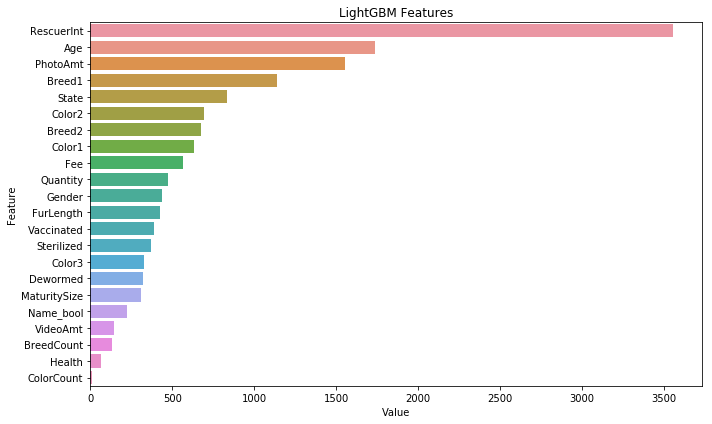

In [124]:
model = lgb.LGBMClassifier()
model.fit(x_train, y_train)

feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,x_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(10, 6))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()


features_selection = SelectFromModel(model, threshold='1.25*median') # The Threshold is the median of features importance*1.25 
features_selection.fit(x_train, y_train)


features_selection_support = features_selection.get_support()
features_selection = x_train.loc[:,features_selection_support].columns.tolist()

In [130]:
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(x_train, y_train)

print ('LightGBM Score all features', lgb_model.score(x_test,y_test)) 


LightGBM Score all features 0.45027322404371584


In [146]:
#Remove same day adoptions
lgb_model.fit(xa_train,ya_train)
print ('LightGBM Score no same day', lgb_model.score(xa_test,ya_test)) 

LightGBM Score no same day 0.4812953657174763


This model seems to be fairly equivalent to the Random forest, which is not totally unexpected since they're both ensemble methods. Let's tune some hyperparameters and see if we can improve the score any further. 

In [136]:
#Tune Boosting Type 
#iniitalize an empty array
lgb_scores = []

#models to test
lgb_boost = ['gbdt','dart','goss']

for boost in lgb_boost:
    lgb_iter = lgb.LGBMClassifier(boosting_type = boost)
    fit = lgb_iter.fit(xa_train,ya_train)
    score = lgb_iter.score(xa_test,ya_test)
    lgb_scores.append(score)
    
max_score = max(lgb_scores)
max_idx = lgb_scores.index(max(lgb_scores))
best_fit = lgb_boost[max_idx]

print ('Scores', lgb_scores)
print('Best Score', max_score, 'from', best_fit, 'boosting type.')
    

Scores [0.4812953657174763, 0.4723618090452261, 0.4617532104969291]
Best Score 0.4812953657174763 from gbdt boosting type.


In [143]:
#Tune Number of Estimators
#iniitalize an empty array
lgb_scores = []

#models to test
estimators = [1, 10, 50, 100, 250, 350, 500, 1000, 5000]

for estim in estimators:
    lgb_iter = lgb.LGBMClassifier(boosting_type = 'gbdt', n_estimators = estim)
    fit = lgb_iter.fit(xa_train,ya_train)
    score = lgb_iter.score(xa_test,ya_test)
    lgb_scores.append(score)
    
max_score = max(lgb_scores)
max_idx = lgb_scores.index(max(lgb_scores))
best_fit = estimators[max_idx]

print ('Scores', lgb_scores)
print('Best Score', max_score, 'from', best_fit, '#estimators.')
    

Scores [0.32384142936906757, 0.4528196538246789, 0.4768285873813512, 0.4812953657174763, 0.46957007258514794, 0.474036850921273, 0.47459519821328866, 0.4701284198771636, 0.4539363484087102]
Best Score 0.4812953657174763 from 100 boosting type.


Looks like hypertuning isn't helping much with this model, since the best scores are coming from the default model settings, so let's go ahead and run a final analysis with what we've learned on the entire dataset including validation data. Again, we'll run with and without same day adoption to determine the effect. We'll again expect without same day to perform better. 

In [278]:
#All values, all adoption speeds
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(x_all, y_all)

print ('LightGBM Score all data, all adoption speeds', lgb_model.score(x_test_all,y_test_all)) 


LightGBM Score all data, all adoption speeds 0.44649446494464945


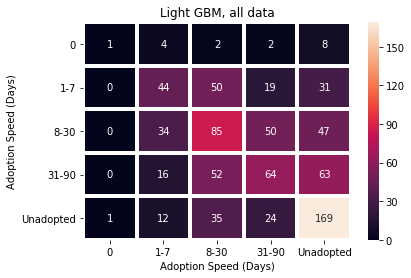

In [291]:
y_pred = lgb_model.predict(x_test_all)
cm_lgb = confusion_matrix(y_test_all,y_pred)

title = 'Light GBM, all data'
cm_plot (cm_lgb, adpt_spd, adpt_spd, title)

# Write confusion matrices to dataframe for later use
matrix_to_frame_all(cm_lgb, 'LightGBM')

In [293]:
#All values, all adoption speeds
lgb_modela = lgb.LGBMClassifier()
lgb_modela.fit(x_a_all, y_a_all)

print ('LightGBM Score all data, no same day', lgb_modela.score(x_atest_all,y_atest_all)) 

LightGBM Score all data, no same day 0.45671267252195735


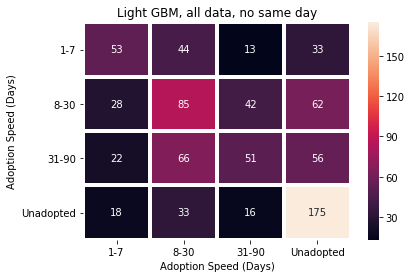

In [296]:
ya_pred = lgb_modela.predict(x_atest_all)
cm_lgba = confusion_matrix(y_atest_all,ya_pred)

title = 'Light GBM, all data, no same day'
cm_plot (cm_lgba, adpt_spd_ns, adpt_spd_ns, title)

# Write confusion matrices to dataframe for later use
matrix_to_frame_NS(cm_lgba, 'LightGBM')


| Model | Accuracy Score | All Pets/No Same Day| 
| --- | --- | ---|
|Logistic Regression-liblinear | 0.39483| All Pets |
|Naive Bayes | 0.31242| No Same Day| 
|Linear SVC| 0.27527 | No Same Day | 
|SVC | 0.44668 | No Same Day|
|kNN| 0.41656 | No Same Day |
|Random Forest | 0.48557| No Same Day |
|LightGBM| 0.47679| No Same Day|

In [299]:
#Save both sets of confusion matrix data to CSV 
nosame_data_CMS.to_csv(r'tidy_data/NoSameDay_IdentityMatrices.csv',index=False)
all_data_CMS.to_csv(r'tidy_data/AllData_IdentityMatrices.csv',index=False)

# Final Model Performance

The best model choice ended up being Random Forest, which was not unexpected. This method along with LightGBM and XGBoost tend to be most successful in Kaggle competitions. Some of these findings were very unexpected, having looked at many of the other Kaggle notebooks submitted during this competition. The difference in findings can easily be attributed to dropping cats out of the dataset. However, I found it interesting that even without analyzing the descriptions, the final score was comparable to that found by the leader in the kaggle competition. Overall, the findings were consistent with what is understood in real-world dog adoptions. It’s very difficult to predict which animals will be adopted on the same day, and is more or less random. The likelihood a dog will be adopted probably has less to do with the animal and more to do with pet trends, seasons, and what people are looking for in a dog. Or, perhaps it’s like every other relationship we have as humans, and it’s all based on that instant connection an adopter has when meeting a pet. 

Overall model results are summarized in the table below: 

![alt text](Imgs/ModelSummary.png "FinalModelScores")


Finally, let's take a look at how these models compared to each other when looking at just the identity matrix (corretly classified pets) for each confusion matrix. This can be used by each rescue agency for developing the best plan to get pets adopted. Data can be processed mutiple ways to determine which pets will be higher risk for going unadopted, so they need to be placed with a specific rescue. It also allows for rescues to shuffle pets more strategically. By using the right model to predict which pets will be adopted in under a month allows the agency to identify which pets will need to be relocated or have special marketing. It also gives them a set time frame for those special cases to move them on to another rescue that is no-kill, ultimately resulting in the best opportunity for adoption. 

<Figure size 1080x720 with 0 Axes>

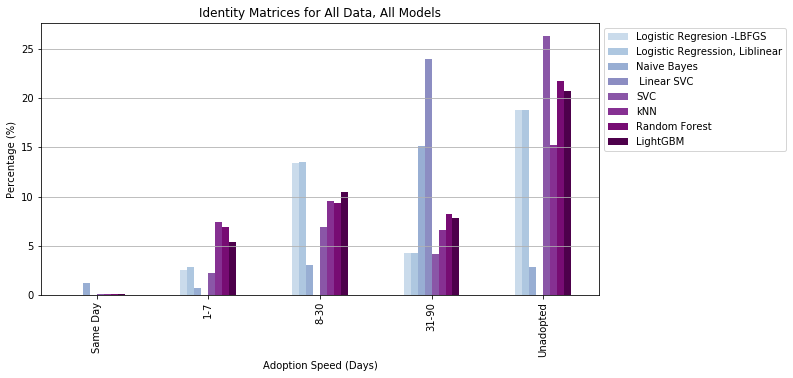

In [357]:
cmap = mpl.cm.BuPu(np.linspace(0,1,20))
cmap = mpl.colors.ListedColormap(cmap[4:,:-1])

plt.figure(figsize=(15,10))
all_data_CMS.plot.bar(xlabel = 'Adoption Speed (Days)', ylabel='Percentage (%)', 
                      title='Identity Matrices for All Data, All Models', colormap= cmap) 
lgd = plt.legend(bbox_to_anchor=(1,1))
plt.grid(b=None, which='major', axis='y')
plt.gcf().set_size_inches(10, 5)

#save plot
plt.savefig(r'Figures/AllData_IdentityMatrices.png',bbox_extra_artists=(), bbox_inches='tight')

<Figure size 1080x720 with 0 Axes>

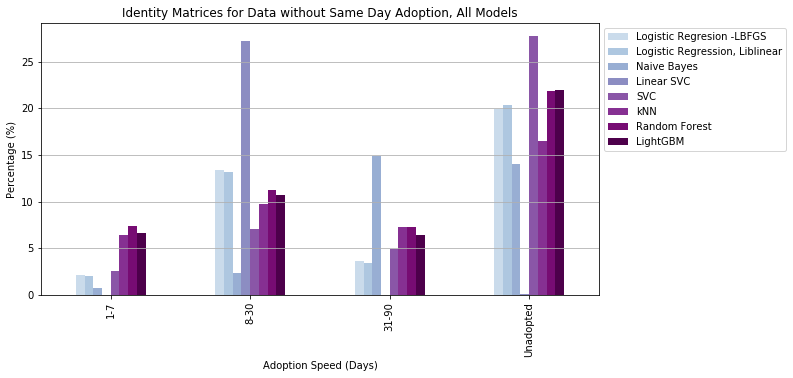

In [358]:
plt.figure(figsize=(15,10))
nosame_data_CMS.plot.bar(xlabel = 'Adoption Speed (Days)', ylabel='Percentage (%)', 
                         title='Identity Matrices for Data without Same Day Adoption, All Models',
                         colormap= cmap) 
lgd = plt.legend(bbox_to_anchor=(1,1))
plt.grid(b=None, which='major', axis='y')
plt.gcf().set_size_inches(10, 5)

#save plot
plt.savefig(r'Figures/NoSameDayData_IdentityMatrices.png',bbox_extra_artists=(), bbox_inches='tight')

So the first step would be to run a logistic regression model using a liblinear solver, and fingers crossed those pets do get adopted same day! Then a rescue would want to run LinearSVC and go ahead and plan to keep those pets who will be adopted in the first month. A Naive Bayes model gives you those pets who will need a more long term living situation, but still have a pretty good chance of being adopted. SVC, kNN, Random Forest, or Light GBM can give a rescue insight onto the toughest case dogs, those that won't be adopted. This gives every animal the best chance of getting the necessary attention to find a home. 